In [1]:
!rm -rf *
!git config --global user.name "Akhilez"
!git config --global user.email "akhild18@yahoo.com"
!git clone https://github.com/Akhilez/ml_gallery.git
%cd ml_gallery/ml_py

Cloning into 'ml_gallery'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (507/507), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 2034 (delta 293), reused 315 (delta 135), pack-reused 1527
Receiving objects: 100% (2034/2034), 11.65 MiB | 10.28 MiB/s, done.
Resolving deltas: 100% (1231/1231), done.
/content/ml_gallery/ml_py


In [2]:
import os
os.environ['SECRET_KEY'] = '1234'
%mkdir -p data/mnist/numbers

In [3]:
import torch
from torch.nn.functional import relu
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
aug = MNISTAug()
dm = DataManager()
dm.load()

In [7]:
x_train, y_train = aug.get_augmented(dm.x_train, dm.y_train, 1000)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [8]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

[{'class': tensor(3),
  'class_one_hot': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  'cx': 104.5,
  'cy': 86.5,
  'height': 15,
  'width': 15,
  'x1': 97,
  'x2': 112,
  'y1': 79,
  'y2': 94}]

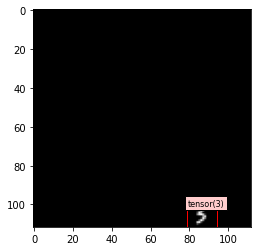

In [9]:
DataManager.plot_num(x_train[1].reshape((112, 112)), y_train[1])
y_train[1]

In [10]:
anchor_cx = 56
anchor_cy = 56
anchor_w = 28

In [11]:
def units_to_diff(y):
    y_d = []
    for i in range(len(y)):
        cx_d = (y[i][0]['cx'] - anchor_cx) / 112
        cy_d = (y[i][0]['cy'] - anchor_cy) / 112
        w_d = (y[i][0]['width'] - anchor_w) / 112
        y_d.append((cx_d, cy_d, w_d))
    return torch.tensor(y_d)

def diff_to_units(y):
    y_units = []
    for i in range(len(y)):
        cx_d = y[i][0] * 112 + anchor_cx
        cy_d = y[i][1] * 112 + anchor_cy
        wd = y[i][2] * 112 + anchor_w
        y_units.append((cx_d, cy_d, wd))
    return torch.tensor(y_units)

In [12]:
y_d = units_to_diff(y_train)
y_d_test = units_to_diff(y_test)

In [15]:
class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.linear2 = torch.nn.Linear(4096, 512)
        self.linear3 = torch.nn.Linear(512, 3)

    def forward(self, x):
        x = relu(self.conv1(x))  # 112
        x = relu(self.conv2(x))  # 56
        x = relu(self.conv3(x))  # 28
        x = relu(self.conv4(x))  # 14
        x = relu(self.conv5(x))  # 7
        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = torch.nn.functional.tanh(self.linear3(x))
        return x


class Classifier (torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.

model = DetectorV1().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [17]:
epochs = 10
batch_size = 100

for epoch in range(epochs):
    
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index].to(device)
        y_batch = y_d[start_index:end_index].to(device)
        
        optimizer.zero_grad()

        y_hat = model(x_batch)

        loss = sum(sum((y_batch - y_hat)**2))
        
        loss.backward()
        optimizer.step()
        
    print(f'Epoch: {epoch}, loss={float(loss)}')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 0, loss=1.55461585521698
Epoch: 1, loss=0.9850618839263916
Epoch: 2, loss=0.40620675683021545
Epoch: 3, loss=0.2603498697280884
Epoch: 4, loss=0.355426549911499
Epoch: 5, loss=0.18558809161186218
Epoch: 6, loss=0.15935498476028442
Epoch: 7, loss=0.13240544497966766
Epoch: 8, loss=0.10754375159740448
Epoch: 9, loss=0.08911023288965225


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


y_pred: tensor([[-0.0996,  0.3411,  0.0275],
        [ 0.2852, -0.2837,  0.0070]], device='cuda:0')
y_d_test: tensor([[-0.0982,  0.3482,  0.0179],
        [ 0.2946, -0.2946,  0.0179]])
[{'x1': 29.31041717529297, 'y1': 78.66602325439453, 'x2': 60.38934326171875, 'y2': 109.74495697021484}]
[{'x1': 73.55078887939453, 'y1': 9.832630157470703, 'x2': 102.33081817626953, 'y2': 38.61266326904297}]


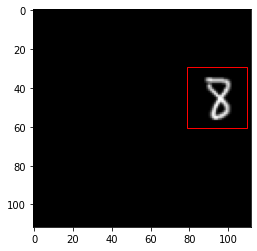

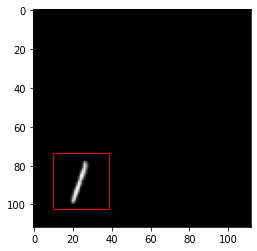

In [21]:
with torch.no_grad():
    y_pred = model(x_test.to(device))
    
    print(f'y_pred: {y_pred}\ny_d_test: {y_d_test}')
    
    y_pred = diff_to_units(y_pred)
    for i in range(len(y_pred)):

        cx_pred, cy_pred, w_pred = y_pred[i]
        pred_boxes = [{
            'x1': float(cx_pred - w_pred / 2),
            'y1': float(cy_pred - w_pred / 2),
            'x2': float(cx_pred + w_pred / 2),
            'y2': float(cy_pred + w_pred / 2)
        }]

        # pred_boxes.extend(list(y_test[i]))
        print(f'{pred_boxes}')

        DataManager.plot_num(x_test[i].reshape((112, 112)), pred_boxes)
